In [14]:
%load_ext autoreload
%autoreload 2

In [20]:
from longeval.spark import get_spark
import os
import pandas as pd

os.environ['SPARK_LOCAL_DIR'] = '/home/ap/github/longeval-2025/.venv/lib/python3.10/site-packages/pyspark'
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-11-openjdk-amd64' 
os.environ['SPARK_HOME'] = '/opt/spark-3.5.4-bin-hadoop3'

data_root = "../../data/longeval"

spark = get_spark()
spark.sparkContext.setLogLevel("ERROR")
spark



In [21]:
data_root = "../../data/longeval"
! tree {data_root} -L 3

../../data/longeval
├── 2023_01
│   ├── English
│   │   ├── Documents
│   │   ├── Qrels
│   │   └── Queries
│   └── French
│       ├── Documents
│       ├── Qrels
│       └── Queries
└── count_docs.sh

9 directories, 1 file


In [22]:
import os
os.environ['PYSPARK_DRIVER_MEMORY'] = '16G'
print(os.environ.get('PYSPARK_DRIVER_MEMORY'))

16G


In [23]:
from longeval.collection import RawCollection

# according to a simple grep, there are 1759690 documents in the collection
train_eng = RawCollection(
    spark, f"{data_root}/2023_01/English"
)
docs = train_eng.documents.cache()
print(docs.count())
docs.show(5, vertical=True, truncate=80)
docs.printSchema()

1260
-RECORD 0------------------------------------------------------------------------------------
 contents | Forget the Nukes:\nTunnels\nAre North\nKorea's Secret Weapon\n|\nThe\nNationa... 
 docid    | doc012310000001                                                                  
-RECORD 1------------------------------------------------------------------------------------
 contents | Project Perfect Mod ::\nView topic\n- Who will take over the island?\nDo you ... 
 docid    | doc012310000002                                                                  
-RECORD 2------------------------------------------------------------------------------------
 contents | "Lawyer James B. Donovan, widely known for negotiating the release of...\nNie... 
 docid    | doc012310000003                                                                  
-RECORD 3------------------------------------------------------------------------------------
 contents | What Rex Tillerson'\ns Nomination Means for

In [24]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, explode, collect_list, expr
from pyspark.sql.types import ArrayType, StringType, IntegerType
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.clustering import LDA
import numpy as np
from pyspark.sql.functions import col, array_max, array_position


# Assuming Spark session is already created
spark = SparkSession.builder.appName("LDA Example").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

# Step 1: Tokenization
tokenizer = Tokenizer(inputCol="contents", outputCol="words")
tokenized = tokenizer.transform(docs)

# Step 2: Remove Stopwords
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
filtered = remover.transform(tokenized)

# Step 3: Convert Words to Features using CountVectorizer
vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="features")
vector_model = vectorizer.fit(filtered)
vectorized_docs = vector_model.transform(filtered)
# vectorized_docs.printSchema()  

# Step 4: Train LDA Model
k = 20  # Number of topics to extract
lda = LDA(k=k, maxIter=10, featuresCol="features", optimizer="em")
lda_model = lda.fit(vectorized_docs)

# Step 5: Extract Topics
topics = lda_model.describeTopics(maxTermsPerTopic=100)
vocab = vector_model.vocabulary  # Get vocabulary

# Ensure the vocabulary is not empty
if not vocab:
    raise ValueError("Vocabulary is empty. Please check the CountVectorizer step.")

# topics.show(truncate=False)  # This will display all topics without truncating

# Step 6: Map topics to words
topic_words = {}
for row in topics.collect():
    topic_index = row.topic
    term_indices = row.termIndices
    terms = [vocab[index] for index in term_indices]  # Map indices to words
    topic_words[topic_index] = terms

# Print the mapped topics to words
for topic, words in topic_words.items():
    print(f"Topic {topic}: {', '.join(words)}")


topic_distributions = lda_model.transform(vectorized_docs)

# topic_distributions.printSchema()
# # Show the first few rows of topic_distributions
# topic_distributions.show(truncate=False)
# topic_distributions.head(3)


# Step 8: Select the relevant columns
doc_topic_df = topic_distributions.select("docid", "topicDistribution").toPandas()
# Extract the topic probabilities as a NumPy array
doc_topic_array = np.vstack(doc_topic_df["topicDistribution"].apply(lambda v: v.toArray()))
# Step 7: Identify the topic with the highest probability
doc_topic_df['highest_topic'] = np.argmax(doc_topic_array, axis=1)  # Get index of the highest topic
# Convert the topic probabilities array back to a DataFrame
topic_probabilities_df = pd.DataFrame(doc_topic_array, columns=[f'topic_{i}' for i in range(doc_topic_array.shape[1])])
# Concatenate the docid, highest_topic, and topic probabilities
result_df = pd.concat([doc_topic_df[['docid']], 
                       pd.DataFrame({'highest_topic': doc_topic_df['highest_topic']}), 
                       topic_probabilities_df], axis=1)

result_df.head(10)




Topic 0:  , -, montmagny, 1, use, /, 5, ,, one, also, new, free, information, may, 2, &, water, montmagny., us, 3, :, first, individual, please, services, open, repair, 4, •, general, support, make, good, hotel, time, see, search, foam, like, $, made, france, focus, +, service, must, 0, data, 10, remediation, collection, without, take, year, |, rated, create, contact, available, health, (, view, find, 6, change, 2023, get, much, years, *, ., springs, brilliant, –, average, work, need, two, , 2022, city, know, day, click, grease, right, number, site, km, files, used, €, even, last, many, air, name, well, united, email
Topic 1: -, best, new, film, ,, /, 1, award, de, one, may, also, 2, km, france, first, time, winning, 3, use, card, life, us, takes, share, like, |, ..., see, euro, 5, (, information, festival, contact, black, international, take, french, good, 2012, –, photo, :, 2011, war, two, 2017, years, social, 10, avenue, water, book, volvo, member, &, 2018, search, free, city, hotel

,docid,highest_topic,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,doc012310000001,15,0.012663,0.014262,0.008591,0.016829,0.012025,0.375100,0.006941,0.008288,...,0.013387,0.007428,0.005712,0.016934,0.009465,0.402358,0.009967,0.015374,0.009536,0.019632
1,doc012310000002,10,0.005596,0.005094,0.006606,0.005671,0.004861,0.005077,0.005239,0.004868,...,0.888313,0.005278,0.005657,0.005279,0.005381,0.005414,0.005470,0.005321,0.005089,0.014208
2,doc012310000003,5,0.003912,0.004064,0.004314,0.003942,0.004038,0.916477,0.004340,0.004262,...,0.003961,0.004072,0.004354,0.003945,0.003993,0.009706,0.003950,0.004260,0.004047,0.004241
3,doc012310000004,11,0.014080,0.068443,0.031435,0.057604,0.030868,0.028030,0.014775,0.012804,...,0.014521,0.529106,0.010386,0.013900,0.027416,0.016058,0.012190,0.042816,0.010283,0.013985
4,doc012310000005,18,0.002074,0.002415,0.002068,0.002090,0.002023,0.002093,0.002292,0.002080,...,0.002156,0.002080,0.002136,0.002028,0.002066,0.004503,0.002068,0.002237,0.957024,0.002242
5,doc012310000006,14,0.003796,0.004075,0.005067,0.054648,0.003697,0.006552,0.007195,0.003901,...,0.005076,0.004765,0.006789,0.004353,0.844817,0.008707,0.003682,0.007137,0.007341,0.004682
6,doc012310000007,9,0.005999,0.014929,0.020400,0.018412,0.007279,0.032493,0.009417,0.007134,...,0.010605,0.007327,0.010610,0.027660,0.012904,0.007852,0.005805,0.016788,0.005845,0.072805
7,doc012310000008,1,0.008953,0.377323,0.009844,0.075870,0.017758,0.030975,0.007933,0.015160,...,0.009572,0.334415,0.008685,0.007654,0.010786,0.008667,0.008074,0.006807,0.007135,0.025178
8,doc012310000009,3,0.047118,0.024044,0.024336,0.472316,0.022321,0.019257,0.018172,0.015006,...,0.018349,0.021428,0.015548,0.078181,0.053482,0.013570,0.013983,0.019338,0.018132,0.028806
9,doc012310000010,15,0.004047,0.004025,0.007984,0.046724,0.004181,0.006874,0.006921,0.003830,...,0.004228,0.004753,0.004408,0.004691,0.004251,0.866370,0.004106,0.004651,0.004350,0.004553


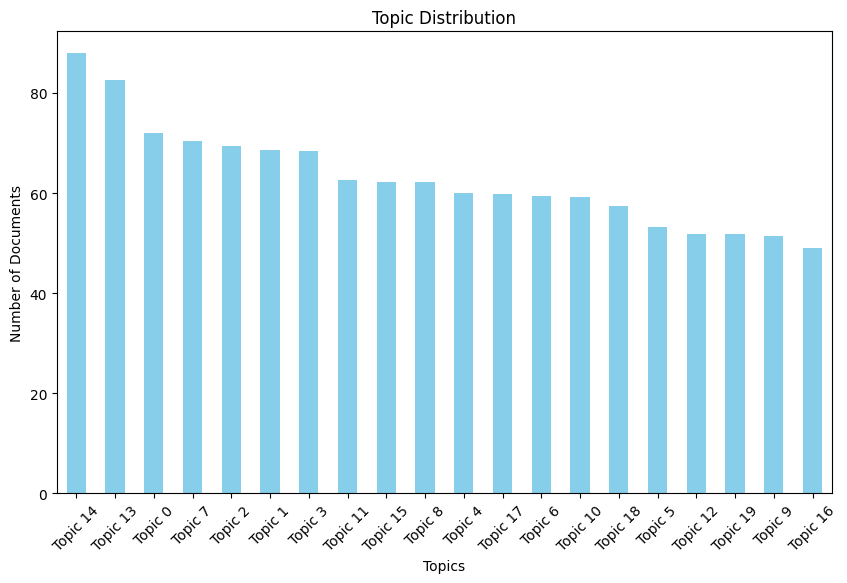

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Step 8: Get Topic Distribution for Each Document
topic_distribution = lda_model.transform(vectorized_docs)

# Step 9: Count Documents per Topic
# Extract the topic distribution into a DataFrame
# First, we need to create a new DataFrame with the topic distribution as a list
topic_distribution_list = topic_distribution.select("topicDistribution").collect()

# Create a DataFrame with topic counts
topic_counts = []

# Iterate over each row of topic distributions and sum the occurrences of each topic
for row in topic_distribution_list:
    topic_counts.append(row.topicDistribution)

# Convert list of topic distributions into a DataFrame
topic_counts_df = pd.DataFrame(topic_counts, columns=[f'Topic {i}' for i in range(k)])

# Sum the occurrences of each topic
topic_sums = topic_counts_df.sum().sort_values(ascending=False)

# Step 10: Plot the T16Gopic Distribution
plt.figure(figsize=(10, 6))
topic_sums.plot(kind='bar', color='skyblue')
plt.title('Topic Distribution')
plt.xlabel('Topics')
plt.ylabel('Number of Documents')
plt.xticks(rotation=45)
plt.show()

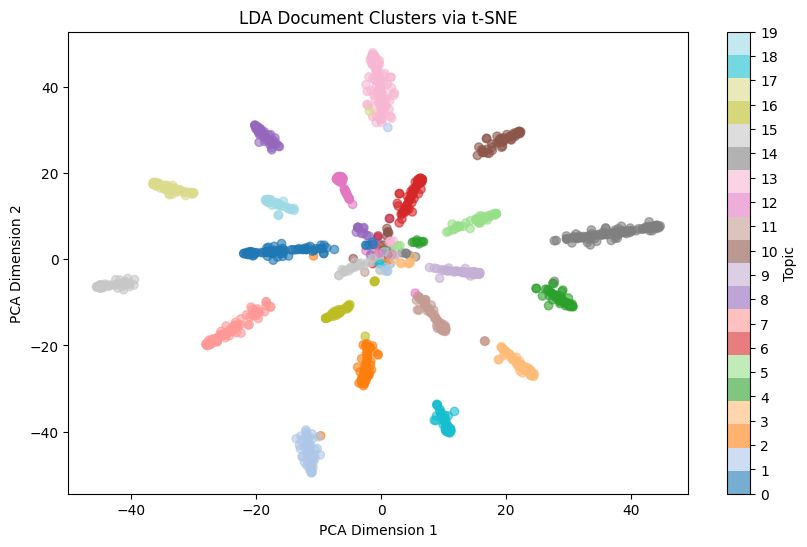

In [26]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.clustering import LDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# # Assuming Spark session is already created
# spark = SparkSession.builder.appName("LDA Example").getOrCreate()
# spark.sparkContext.setLogLevel("ERROR")

# # Step 1: Tokenization
# tokenizer = Tokenizer(inputCol="contents", outputCol="words")
# tokenized = tokenizer.transform(docs)

# # Step 2: Remove Stopwords
# remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
# filtered = remover.transform(tokenized)

# # Step 3: Convert Words to Features using CountVectorizer
# vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="features")
# vector_model = vectorizer.fit(filtered)
# vectorized_docs = vector_model.transform(filtered)

# # Step 4: Train LDA Model
# k = 20  # Number of topics to extract
# lda = LDA(k=k, maxIter=10, featuresCol="features", optimizer="em")
# lda_model = lda.fit(vectorized_docs)

# Step 5: Transform documents into topic distributions
doc_topics = lda_model.transform(vectorized_docs)  # Output: Soft assignment of docs to topics

# Step 6: Extract topic distributions as numpy array
# doc_topic_array = np.array(doc_topics.select("topicDistribution").rdd.map(lambda x: x[0]).collect())
doc_topic_df = doc_topics.select("topicDistribution").toPandas()
doc_topic_array = np.vstack(doc_topic_df["topicDistribution"].apply(lambda v: v.toArray()))

# Step 7: Reduce dimensionality using PCA (or t-SNE for better visualization)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
doc_topic_2d = tsne.fit_transform(doc_topic_array)

# Step 8: Assign each document to its dominant topic
dominant_topics = np.argmax(doc_topic_array, axis=1)

# Step 9: Convert to Pandas DataFrame for plotting
df_plot = pd.DataFrame({
    "x": doc_topic_2d[:, 0],
    "y": doc_topic_2d[:, 1],
    "topic": dominant_topics
})

# Step 10: Plot scatterplot
plt.figure(figsize=(10, 6))

# Use tab20 since we have 20 topics
scatter = plt.scatter(df_plot["x"], df_plot["y"], c=df_plot["topic"], cmap="tab20", alpha=0.6)

# Create a colorbar and ensure proper topic labels
cbar = plt.colorbar(scatter, label="Topic")
cbar.set_ticks(range(k))  # Ensure colorbar has topic labels from 0 to k-1
cbar.set_ticklabels(range(k))  # Label each tick correctly

plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.title("LDA Document Clusters via t-SNE")
plt.show()

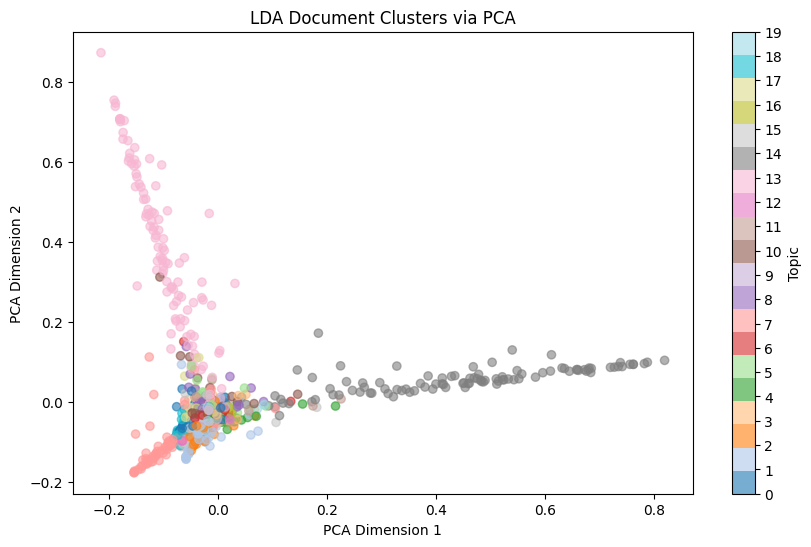

In [27]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.clustering import LDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# # Assuming Spark session is already created
# spark = SparkSession.builder.appName("LDA Example").getOrCreate()
# spark.sparkContext.setLogLevel("ERROR")

# # Step 1: Tokenization
# tokenizer = Tokenizer(inputCol="contents", outputCol="words")
# tokenized = tokenizer.transform(docs)

# # Step 2: Remove Stopwords
# remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
# filtered = remover.transform(tokenized)

# # Step 3: Convert Words to Features using CountVectorizer
# vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="features")
# vector_model = vectorizer.fit(filtered)
# vectorized_docs = vector_model.transform(filtered)

# # Step 4: Train LDA Model
# k = 20  # Number of topics to extract
# lda = LDA(k=k, maxIter=10, featuresCol="features", optimizer="em")
# lda_model = lda.fit(vectorized_docs)

# Step 5: Transform documents into topic distributions
doc_topics = lda_model.transform(vectorized_docs)  # Output: Soft assignment of docs to topics

# Step 6: Extract topic distributions as numpy array
# doc_topic_array = np.array(doc_topics.select("topicDistribution").rdd.map(lambda x: x[0]).collect())
doc_topic_df = doc_topics.select("topicDistribution").toPandas()
doc_topic_array = np.vstack(doc_topic_df["topicDistribution"].apply(lambda v: v.toArray()))

# Step 7: Reduce dimensionality using PCA (or t-SNE for better visualization)
pca = PCA(n_components=2)  # Reduce to 2D
doc_topic_2d = pca.fit_transform(doc_topic_array)

# Step 8: Assign each document to its dominant topic
dominant_topics = np.argmax(doc_topic_array, axis=1)

# Step 9: Convert to Pandas DataFrame for plotting
df_plot = pd.DataFrame({
    "x": doc_topic_2d[:, 0],
    "y": doc_topic_2d[:, 1],
    "topic": dominant_topics
})

# Step 10: Plot scatterplot
plt.figure(figsize=(10, 6))

# Use tab20 since we have 20 topics
scatter = plt.scatter(df_plot["x"], df_plot["y"], c=df_plot["topic"], cmap="tab20", alpha=0.6)

# Create a colorbar and ensure proper topic labels
cbar = plt.colorbar(scatter, label="Topic")
cbar.set_ticks(range(k))  # Ensure colorbar has topic labels from 0 to k-1
cbar.set_ticklabels(range(k))  # Label each tick correctly

plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.title("LDA Document Clusters via PCA")
plt.show()

In [28]:
import pandas as pd
from IPython.display import display, HTML

topics = {
    0: {"name": "Club & Event Organization/Athletics", "description": "Focus on committees, athletic events, and related organization"},
    1: {"name": "General Information & Service Inquiries", "description": "Broad terms related to information requests, services, and general help"},
    2: {"name": "Film Festivals & Entertainment", "description": "Emphasis on film awards, festivals, and related entertainment topics"},
    3: {"name": "Online Purchases & Medical/Technical Items", "description": "Focus on online orders, pharmaceuticals, and technical equipment"},
    4: {"name": "Personalities & Historical Data", "description": "Mix of names, dates, and file-related terms, suggesting archival or personal data"},
    5: {"name": "Product Reviews & Hotel/Event Planning", "description": "A blend of product feedback, event planning, and hotel-related terms"},
    6: {"name": "Product Specifications & Online Retail", "description": "Focus on product details, features, and online shopping terms"},
    7: {"name": "Vehicle Specifications & Online Forums", "description": "Emphasis on car models, specifications, and online discussion forums"},
    8: {"name": "Online Forums & Communication", "description": "Focus on forum interactions, messages, and general communication"},
    9: {"name": "General Information & Product Listings", "description": "Broad terms related to information, products, and general listings"},
    10: {"name": "Electrical Services & Installations", "description": "Focus on electrical work, installations, and related services"},
    11: {"name": "General Information & Hotel/Travel Inquiries", "description": "Broad terms related to information, hotel bookings, and travel details"},
    12: {"name": "Online Pharmacies & Medical Treatments", "description": "Focus on online pharmaceutical sales and medical treatments"},
    13: {"name": "Online Orders & Product Availability", "description": "Emphasis on online ordering, delivery, and product stock"},
    14: {"name": "Social Media Analytics & Hotel Bookings", "description": "A blend of social media metrics and hotel reservation terms"},
    15: {"name": "Sports Events & Film Production", "description": "Focus on sports competitions and film production roles"},
    16: {"name": "Online Retail & Local/Regional Information", "description": "Mix of product sales, regional information, and public services"},
    17: {"name": "Travel Bookings & Local Information", "description": "Emphasis on travel reservations and local area details"},
    18: {"name": "Vehicle Specifications & Online Sales", "description": "Focus on vehicle details, sales, and related technical terms"},
    19: {"name": "Film Awards & Online Retail/Services", "description": "A blend of film awards and online shopping/service terms"}
}

data = []
for topic_num, topic_info in topics.items():
    data.append({"Topic Number": topic_num, "Topic Name": topic_info["name"], "Topic Description": topic_info["description"]})

df = pd.DataFrame(data)

# Display as HTML table for better presentation in Jupyter Notebook
display(HTML(df.to_html(index=False)))

Topic Number,Topic Name,Topic Description
0,Club & Event Organization/Athletics,"Focus on committees, athletic events, and related organization"
1,General Information & Service Inquiries,"Broad terms related to information requests, services, and general help"
2,Film Festivals & Entertainment,"Emphasis on film awards, festivals, and related entertainment topics"
3,Online Purchases & Medical/Technical Items,"Focus on online orders, pharmaceuticals, and technical equipment"
4,Personalities & Historical Data,"Mix of names, dates, and file-related terms, suggesting archival or personal data"
5,Product Reviews & Hotel/Event Planning,"A blend of product feedback, event planning, and hotel-related terms"
6,Product Specifications & Online Retail,"Focus on product details, features, and online shopping terms"
7,Vehicle Specifications & Online Forums,"Emphasis on car models, specifications, and online discussion forums"
8,Online Forums & Communication,"Focus on forum interactions, messages, and general communication"
9,General Information & Product Listings,"Broad terms related to information, products, and general listings"
